In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans, DBSCAN
import joblib
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

In [ ]:
print("\nLOAD VÀ CHUẨN BỊ DỮ LIỆU")

df = pd.read_csv('../data/processed/featured_data.csv')
print(f"Đã load dữ liệu: {df.shape[0]:,} dòng, {df.shape[1]} cột")


LOAD VÀ CHUẨN BỊ DỮ LIỆU
Đã load dữ liệu: 75,897 dòng, 52 cột


# Chọn features cho mô hình

In [20]:
print("\nChọn features cho mô hình:")

# Features số
numerical_features = [
    'experience_years', 'skills_count', 'fields_count',
    'position_level_encoded', 'exp_position_interaction',
    'skills_exp_interaction', 'salary_range', 'salary_range_ratio'
]

# Binary features từ skills
skill_features = [col for col in df.columns if col.startswith('has_skill_')]

# Binary features từ fields
field_features = [col for col in df.columns if col.startswith('field_')]

# Binary features từ city
city_features = [col for col in df.columns if col.startswith('city_')]

# Tất cả features
all_features = numerical_features + skill_features + field_features + city_features
all_features = [f for f in all_features if f in df.columns]

print(f"   - Numerical features: {len(numerical_features)}")
print(f"   - Skill features: {len(skill_features)}")
print(f"   - Field features: {len(field_features)}")
print(f"   - City features: {len(city_features)}")
print(f"   - TỔNG SỐ FEATURES: {len(all_features)}")

# Target variable
target = 'salary_avg_vnd'


Chọn features cho mô hình:
   - Numerical features: 8
   - Skill features: 10
   - Field features: 10
   - City features: 10
   - TỔNG SỐ FEATURES: 38


# Xử lý missing values

In [21]:
print("\nKiểm tra và xử lý missing values:")
missing = df[all_features + [target]].isnull().sum()
if missing.sum() > 0:
    print("Các cột có missing values:")
    print(missing[missing > 0])
    df = df.dropna(subset=all_features + [target])
    print(f"Đã xóa {missing.sum()} dòng có missing values")
else:
    print("Không có missing values!")

print(f"Số dòng sau xử lý: {len(df):,}")


Kiểm tra và xử lý missing values:
Không có missing values!
Số dòng sau xử lý: 75,897


# Tách features và target

In [22]:
X = df[all_features]
y = df[target]

print(f"\nKích thước dữ liệu:")
print(f"   - X shape: {X.shape}")
print(f"   - y shape: {y.shape}")


Kích thước dữ liệu:
   - X shape: (75897, 38)
   - y shape: (75897,)


# CHIA TẬP TRAIN/TEST

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:  {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Chuẩn hóa dữ liệu
print("\nChuẩn hóa dữ liệu (StandardScaler):")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Đã chuẩn hóa train và test set")

# Lưu scaler
joblib.dump(scaler, '../models/scaler.pkl')
print("Đã lưu scaler vào models/scaler.pkl")

Train set: 60,717 samples (80.0%)
Test set:  15,180 samples (20.0%)

Chuẩn hóa dữ liệu (StandardScaler):
Đã chuẩn hóa train và test set
Đã lưu scaler vào models/scaler.pkl


# XÂY DỰNG CÁC MÔ HÌNH BASELINE

In [24]:
# Dictionary lưu kết quả
results = {}

def train_and_evaluate(name, model, X_train, X_test, y_train, y_test):
    """Train mô hình và đánh giá"""
    print(f"\n{name}")
    print("   Training...")
    
    model.fit(X_train, y_train)
    
    # Dự đoán
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Metrics
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Lưu kết quả
    results[name] = {
        'model': model,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2
    }
    
    print(f"   Train MAE:  {train_mae:,.0f} | Test MAE:  {test_mae:,.0f}")
    print(f"   Train RMSE: {train_rmse:,.0f} | Test RMSE: {test_rmse:,.0f}")
    print(f"   Train R²:   {train_r2:.4f} | Test R²:   {test_r2:.4f}")
    
    return model

In [25]:
# Linear Regression
lr_model = train_and_evaluate(
    "Linear Regression",
    LinearRegression(),
    X_train_scaled, X_test_scaled, y_train, y_test
)

# Ridge Regression
ridge_model = train_and_evaluate(
    "Ridge Regression",
    Ridge(alpha=1.0, random_state=42),
    X_train_scaled, X_test_scaled, y_train, y_test
)

# Lasso Regression
lasso_model = train_and_evaluate(
    "Lasso Regression",
    Lasso(alpha=1.0, random_state=42),
    X_train_scaled, X_test_scaled, y_train, y_test
)

# Decision Tree
dt_model = train_and_evaluate(
    "Decision Tree",
    DecisionTreeRegressor(max_depth=10, random_state=42),
    X_train, X_test, y_train, y_test
)

# Random Forest
rf_model = train_and_evaluate(
    "Random Forest",
    RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1),
    X_train, X_test, y_train, y_test
)

# Gradient Boosting
gb_model = train_and_evaluate(
    "Gradient Boosting",
    GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
    X_train, X_test, y_train, y_test
)

# SVR (trên subset do chậm)
print(f"\nSVR (Support Vector Regression)")
print("   Training on subset (5000 samples)...")
subset_size = min(5000, len(X_train_scaled))
X_train_subset = X_train_scaled[:subset_size]
y_train_subset = y_train.iloc[:subset_size]

svr_model = SVR(kernel='rbf', C=100, gamma='scale')
svr_model.fit(X_train_subset, y_train_subset)

y_test_pred_svr = svr_model.predict(X_test_scaled)
test_mae_svr = mean_absolute_error(y_test, y_test_pred_svr)
test_rmse_svr = np.sqrt(mean_squared_error(y_test, y_test_pred_svr))
test_r2_svr = r2_score(y_test, y_test_pred_svr)

results['SVR'] = {
    'model': svr_model,
    'train_mae': np.nan,
    'test_mae': test_mae_svr,
    'train_rmse': np.nan,
    'test_rmse': test_rmse_svr,
    'train_r2': np.nan,
    'test_r2': test_r2_svr
}

print(f"   Test MAE:  {test_mae_svr:,.0f}")
print(f"   Test RMSE: {test_rmse_svr:,.0f}")
print(f"   Test R²:   {test_r2_svr:.4f}")


Linear Regression
   Training...
   Train MAE:  2 | Test MAE:  2
   Train RMSE: 3 | Test RMSE: 3
   Train R²:   0.7423 | Test R²:   0.7411

Ridge Regression
   Training...
   Train MAE:  2 | Test MAE:  2
   Train RMSE: 3 | Test RMSE: 3
   Train R²:   0.7423 | Test R²:   0.7411

Lasso Regression
   Training...
   Train MAE:  3 | Test MAE:  3
   Train RMSE: 4 | Test RMSE: 4
   Train R²:   0.4942 | Test R²:   0.4968

Decision Tree
   Training...
   Train MAE:  0 | Test MAE:  0
   Train RMSE: 0 | Test RMSE: 0
   Train R²:   0.9944 | Test R²:   0.9940

Random Forest
   Training...
   Train MAE:  0 | Test MAE:  0
   Train RMSE: 0 | Test RMSE: 0
   Train R²:   0.9993 | Test R²:   0.9982

Gradient Boosting
   Training...
   Train MAE:  0 | Test MAE:  0
   Train RMSE: 0 | Test RMSE: 0
   Train R²:   0.9970 | Test R²:   0.9965

SVR (Support Vector Regression)
   Training on subset (5000 samples)...
   Test MAE:  1
   Test RMSE: 2
   Test R²:   0.8981


# SO SÁNH CÁC MÔ HÌNH

In [26]:
# Tạo DataFrame so sánh
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test MAE': [results[m]['test_mae'] for m in results.keys()],
    'Test RMSE': [results[m]['test_rmse'] for m in results.keys()],
    'Test R²': [results[m]['test_r2'] for m in results.keys()]
})

comparison_df = comparison_df.sort_values('Test MAE')
print("\nBảng so sánh (sắp xếp theo Test MAE):")
print(comparison_df.to_string(index=False))


Bảng so sánh (sắp xếp theo Test MAE):
            Model  Test MAE  Test RMSE  Test R²
    Random Forest  0.022349   0.243688 0.998174
    Decision Tree  0.096492   0.440381 0.994036
Gradient Boosting  0.161197   0.335646 0.996536
              SVR  0.999495   1.820676 0.898066
Linear Regression  1.991227   2.901585 0.741104
 Ridge Regression  1.991282   2.901585 0.741104
 Lasso Regression  3.083385   4.045213 0.496803


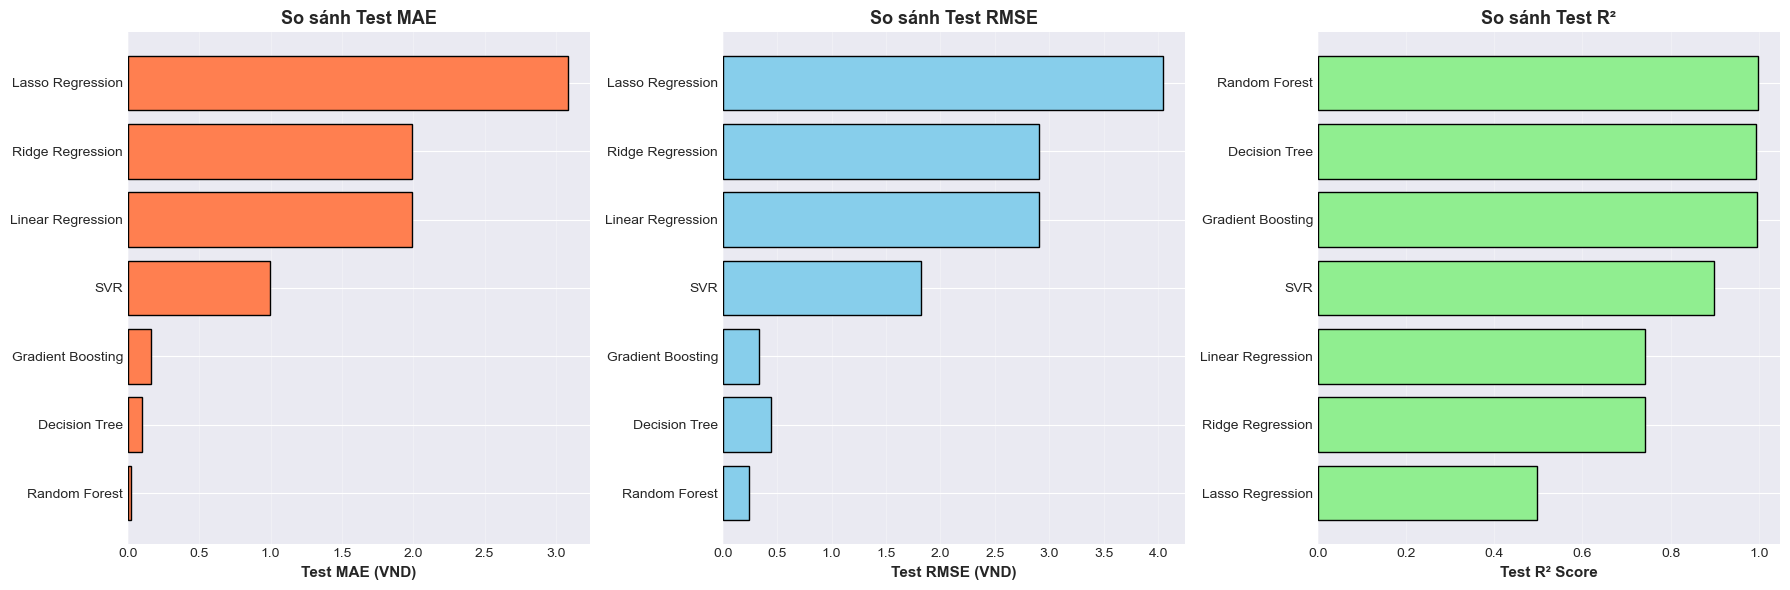


Đã lưu biểu đồ so sánh mô hình!


In [ ]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Test MAE
axes[0].barh(comparison_df['Model'], comparison_df['Test MAE'], color='coral', edgecolor='black')
axes[0].set_xlabel('Test MAE (VND)', fontsize=11, fontweight='bold')
axes[0].set_title('So sánh Test MAE', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Test RMSE
axes[1].barh(comparison_df['Model'], comparison_df['Test RMSE'], color='skyblue', edgecolor='black')
axes[1].set_xlabel('Test RMSE (VND)', fontsize=11, fontweight='bold')
axes[1].set_title('So sánh Test RMSE', fontsize=13, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# Test R²
axes[2].barh(comparison_df['Model'], comparison_df['Test R²'], color='lightgreen', edgecolor='black')
axes[2].set_xlabel('Test R² Score', fontsize=11, fontweight='bold')
axes[2].set_title('So sánh Test R²', fontsize=13, fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)
axes[2].invert_yaxis()

plt.tight_layout()
plt.savefig('./figures/05_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("\nĐã lưu biểu đồ so sánh mô hình!")

In [31]:
# Best model
best_model_name = comparison_df.iloc[0]['Model']
print(f"\nMÔ HÌNH TỐT NHẤT: {best_model_name}")
print(f"   - Test MAE:  {comparison_df.iloc[0]['Test MAE']:,.0f}tr VND")
print(f"   - Test RMSE: {comparison_df.iloc[0]['Test RMSE']:,.0f}tr VND")
print(f"   - Test R²:   {comparison_df.iloc[0]['Test R²']:.4f}")


MÔ HÌNH TỐT NHẤT: Random Forest
   - Test MAE:  0tr VND
   - Test RMSE: 0tr VND
   - Test R²:   0.9982


# HYPERPARAMETER TUNING (CHO RANDOM FOREST)

In [32]:
print("\nGrid Search với Cross-Validation:")

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

print(f"Parameters to search: {param_grid}")
print(f"Total combinations: {np.prod([len(v) for v in param_grid.values()])}")
print("Training... (this may take a while)")

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

print(f"\nBest parameters: {rf_grid.best_params_}")
print(f"Best CV MAE: {-rf_grid.best_score_:,.0f} VND")

# Đánh giá mô hình tối ưu
best_rf = rf_grid.best_estimator_
y_test_pred_best = best_rf.predict(X_test)

test_mae_best = mean_absolute_error(y_test, y_test_pred_best)
test_rmse_best = np.sqrt(mean_squared_error(y_test, y_test_pred_best))
test_r2_best = r2_score(y_test, y_test_pred_best)

print(f"\nKết quả mô hình tối ưu trên Test set:")
print(f"   - Test MAE:  {test_mae_best:,.0f} VND")
print(f"   - Test RMSE: {test_rmse_best:,.0f} VND")
print(f"   - Test R²:   {test_r2_best:.4f}")

# So sánh với baseline RF
print(f"\nSo sánh với baseline Random Forest:")
print(f"   - Cải thiện MAE:  {(results['Random Forest']['test_mae'] - test_mae_best):,.0f} VND")
print(f"   - Cải thiện R²:   {(test_r2_best - results['Random Forest']['test_r2']):.4f}")


Grid Search với Cross-Validation:
Parameters to search: {'n_estimators': [100, 200], 'max_depth': [10, 15, 20], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}
Total combinations: 24
Training... (this may take a while)
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best CV MAE: 0 VND

Kết quả mô hình tối ưu trên Test set:
   - Test MAE:  0 VND
   - Test RMSE: 0 VND
   - Test R²:   0.9983

So sánh với baseline Random Forest:
   - Cải thiện MAE:  0 VND
   - Cải thiện R²:   0.0001


# FEATURE IMPORTANCE ANALYSIS


Top 20 features quan trọng nhất:
                                     feature  importance
                                salary_range    0.549813
                          salary_range_ratio    0.330607
                    exp_position_interaction    0.115457
                      position_level_encoded    0.000944
                      skills_exp_interaction    0.000719
                            experience_years    0.000497
                                fields_count    0.000276
                                skills_count    0.000254
has_skill_bán_hàng_qua_điện_thoại_(telesale)    0.000186
                                city_đà_nẵng    0.000156
                   has_skill_tư_vấn_bán_hàng    0.000152
              has_skill_hành_chính_văn_phòng    0.000114
                            city_hồ_chí_minh    0.000112
                  has_skill_kế_toán_tổng_hợp    0.000097
                             field_marketing    0.000092
                          has_skill_xây_dựng    0.0000

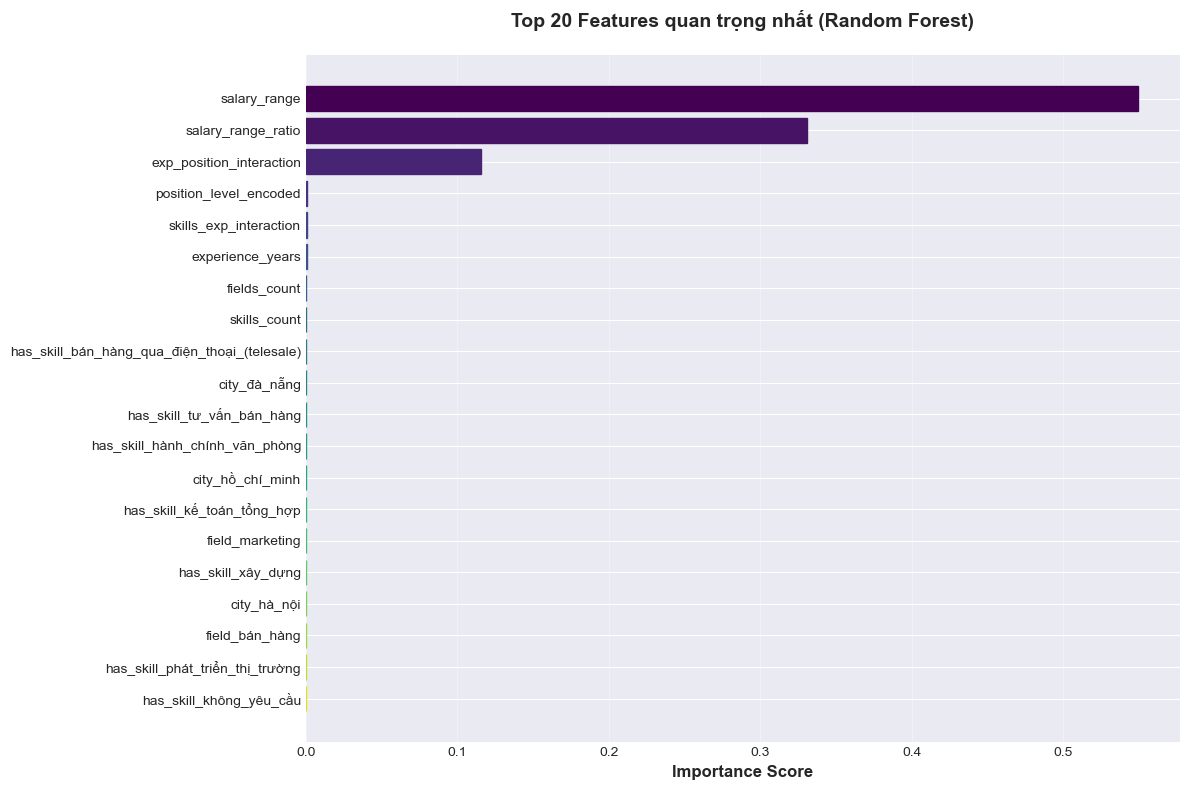


Đã lưu biểu đồ feature importance!


In [ ]:
print("\nTop 20 features quan trọng nhất:")

feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(20).to_string(index=False))

# Visualization
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
bars = plt.barh(top_features['feature'], top_features['importance'], color='teal', edgecolor='black')

# Gradient color
for i, bar in enumerate(bars):
    bar.set_color(plt.cm.viridis(i / len(top_features)))

plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.title('Top 20 Features quan trọng nhất (Random Forest)', fontsize=14, fontweight='bold', pad=20)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('./figures/05_feature_importance.png', dpi=300, bbox_inches='tight')
plt.gca().invert_yaxis()
plt.show()
print("\nĐã lưu biểu đồ feature importance!")

# RESIDUAL ANALYSIS (PHÂN TÍCH SAI SỐ)


RESIDUAL ANALYSIS (PHÂN TÍCH SAI SỐ)


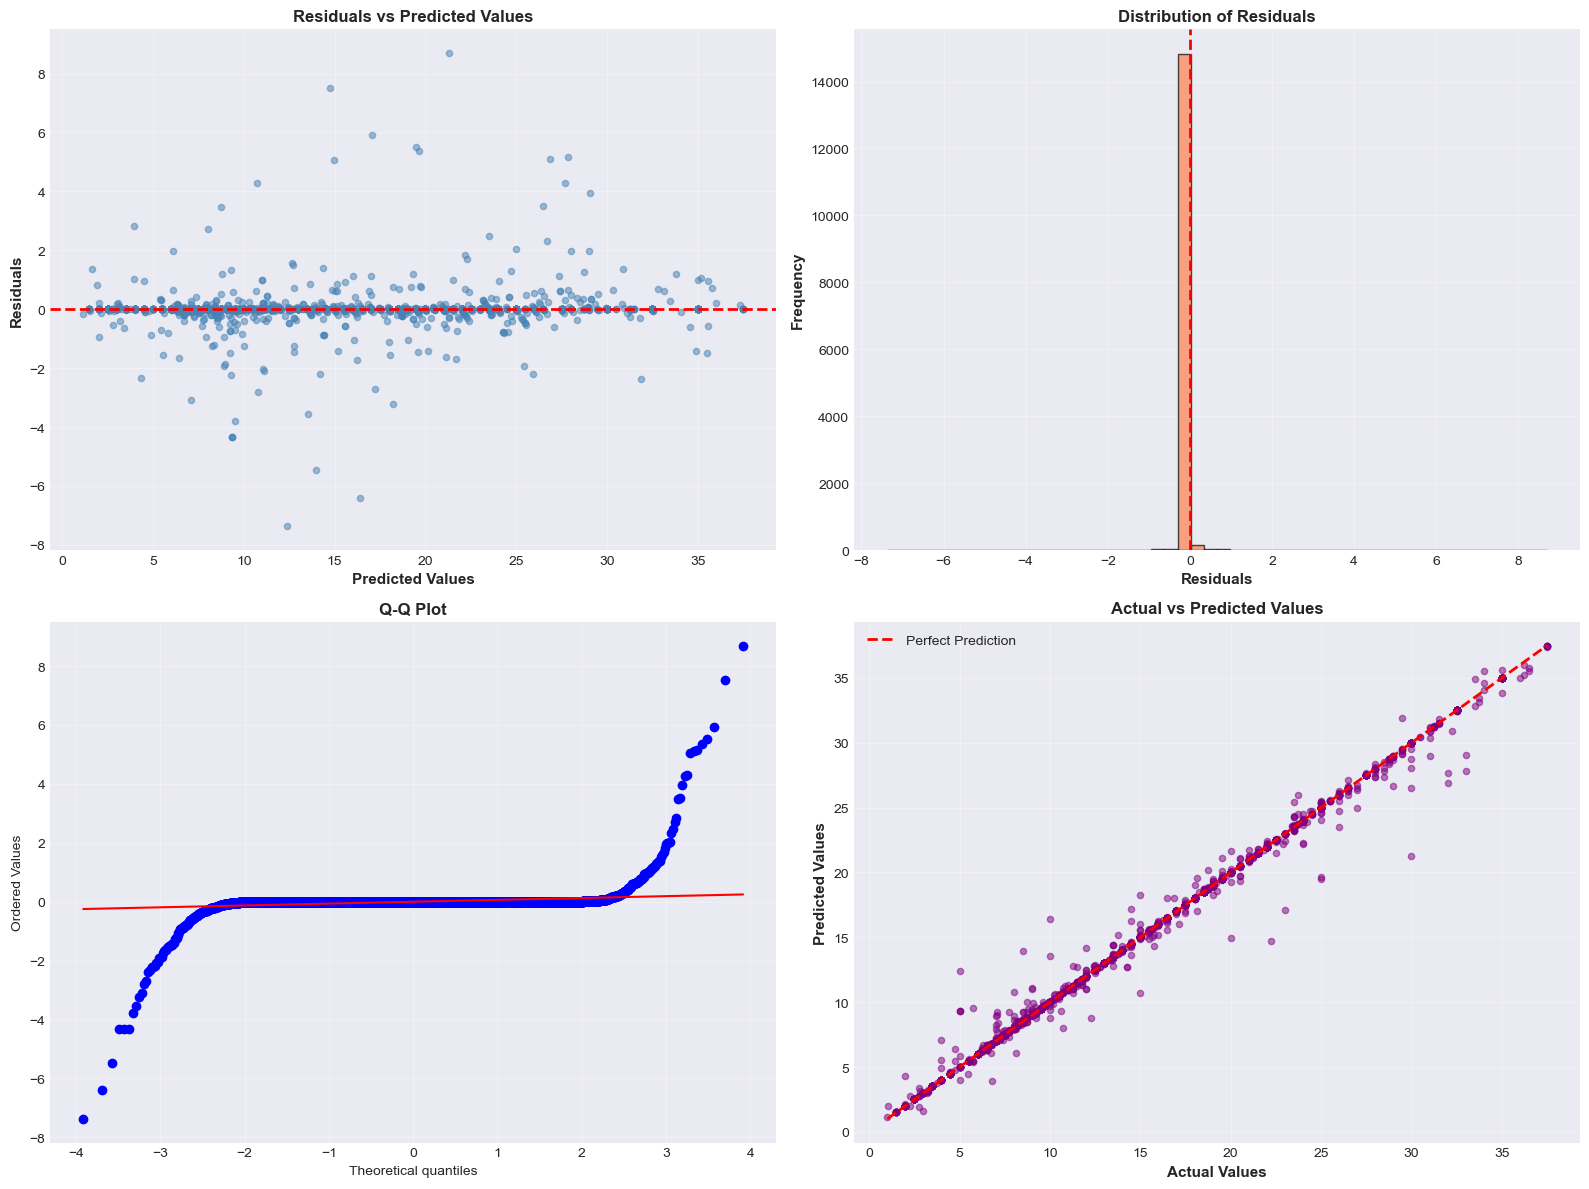


Đã lưu biểu đồ phân tích residuals!


In [ ]:
print("\nRESIDUAL ANALYSIS (PHÂN TÍCH SAI SỐ)")

residuals = y_test - y_test_pred_best

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Residuals vs Predicted
axes[0, 0].scatter(y_test_pred_best, residuals, alpha=0.5, s=20, color='steelblue')
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted Values', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Residuals', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Residuals vs Predicted Values', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Histogram of residuals
axes[0, 1].hist(residuals, bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residuals', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Distribution of Residuals', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Actual vs Predicted
axes[1, 1].scatter(y_test, y_test_pred_best, alpha=0.5, s=20, color='purple')
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual Values', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Predicted Values', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Actual vs Predicted Values', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('./figures/05_residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("\nĐã lưu biểu đồ phân tích residuals!")

# LƯU MÔ HÌNH TỐT NHẤT

In [ ]:
print("\nLƯU MÔ HÌNH TỐT NHẤT")

# Lưu mô hình
joblib.dump(best_rf, '../models/best_model.pkl')
print("Đã lưu mô hình vào models/best_model.pkl")

# Lưu danh sách features
import json
with open('../models/features_list.json', 'w') as f:
    json.dump(all_features, f, indent=2)
print("Đã lưu danh sách features vào models/features_list.json")

# Lưu kết quả
model_info = {
    'model_type': 'RandomForestRegressor',
    'best_params': rf_grid.best_params_,
    'test_mae': float(test_mae_best),
    'test_rmse': float(test_rmse_best),
    'test_r2': float(test_r2_best),
    'n_features': len(all_features),
    'n_train_samples': len(X_train),
    'n_test_samples': len(X_test)
}

with open('../models/model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)
print("Đã lưu thông tin mô hình vào models/model_info.json")

# Lưu comparison results
comparison_df.to_csv('../data/processed/model_comparison.csv', index=False)
print("Đã lưu bảng so sánh mô hình vào model_comparison.csv")

print(f"\nBest Model: {best_model_name} (Optimized)")
print(f"Test MAE: {test_mae_best:,.0f}tr VND")
print(f"Test R²: {test_r2_best:.4f}")


LƯU MÔ HÌNH TỐT NHẤT
Đã lưu mô hình vào models/best_model.pkl
Đã lưu danh sách features vào models/features_list.json
Đã lưu thông tin mô hình vào models/model_info.json
Đã lưu bảng so sánh mô hình vào model_comparison.csv

Best Model: Random Forest (Optimized)
Test MAE: 0tr VND
Test R²: 0.9983
